# Group Analysis

ToDo
----
- Features: analytic amplitudes of frequency bands

Notes
-------
- Best performance (non-time resolved): LinearSVC with 'mean' feature (with downsampling)
    - Performance: ~30% improvement with alignment (where un-aligned is at chance). 
- SideNote: PyMVPA z-scoring within common space seems to boost performance, when performance is otherwise low

In [1]:
#%matplotlib inline

import os
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

from mne import read_epochs
from mne import set_log_level

from hypertools.tools.align import align

# Custom code
import sys
sys.path.append(os.path.join(os.path.dirname(os.getcwd())))
from hypeeg.settings import *
from hypeeg.analysis import *
from hypeeg.utils import *
from hypeeg.plts import *

In [2]:
# Set MNE log level, to shut up print outs
set_log_level('ERROR')

## Settings

In [3]:
# Check the defined settings
print('Within Feat   \t\t:', DEFAULT_AVG)
print('Number of CVs \t\t:', K_FOLD)
print('# Epochs      \t\t:', N_EPOCHS)
print('Alignment     \t\t:', ALIGN)

('Within Feat   \t\t:', 'mean')
('Number of CVs \t\t:', 3)
('# Epochs      \t\t:', 40)
('Alignment     \t\t:', 'hyper')


## Data Organization / Loading

In [4]:
# Set data location for processed files
dat_path = '/Users/jarrodmhicks/Dropbox (MIT)/HyperEEG/CMI/proc'

In [5]:
# Get list of available files
#  Note: this currently excludes first subject, because they are weird.
dat_files = [file for file in os.listdir(dat_path)[1:] if 'epo.fif' in file]

In [6]:
# Load all data
all_subjs = [read_epochs(os.path.join(dat_path, f_name),
                         preload=True, verbose=None) for f_name in dat_files]

In [7]:
# Create time definition vector
times = np.arange(-1, 1, 1./100)

In [8]:
# Organize subject data into data and label matrices
all_data, all_labels = [], []

for subj in all_subjs:
    
    # Enforce a minimum number of trials - skip subj if not met
    if len(subj) < N_EPOCHS:
        print('Skipping Subj')
        continue
        
    #t_data, t_labels = extract_data(subj, l_freq=None, h_freq=None, resample=True)
    t_data, t_labels = extract_data(subj, l_freq=None, h_freq=5, resample=True)
    all_data.append(t_data)
    all_labels.append(t_labels)

Skipping Subj
Skipping Subj
Skipping Subj


In [9]:
np.shape(all_data)

(13, 40, 128, 200)

In [10]:
# Check how many subjects there are
n_subjs = len(all_data)
print('Running ', n_subjs, 'subjects.')

('Running ', 13, 'subjects.')


In [ ]:
# Sanity check: z-score before everything
# ????
#all_data = [make_3d(make_2d(dat)) for dat in all_data]

## Within Subject Classification (un-aligned)


In [11]:
# Run within subject classification - non time resolved
within_scores = within_subj_classification(all_data, all_labels)

In [12]:
# Get average results - within and across subjects
within_subj_avgs = np.mean(within_scores, 1)
within_glob_avg = np.mean(within_subj_avgs)

In [13]:
# Check outcome - average across all subjects
print_avg('CV Within-Subj Prediction', within_glob_avg)

CV Within-Subj Prediction: 50.40%


In [14]:
# Check performance on each subject
print_avgs('Per Subj Within Predictions', within_subj_avgs)

Per Subj Within Predictions:
	0 	 0.50
	1 	 0.50
	2 	 0.65
	3 	 0.43
	4 	 0.50
	5 	 0.47
	6 	 0.50
	7 	 0.50
	8 	 0.50
	9 	 0.50
	10 	 0.50
	11 	 0.50
	12 	 0.50


In [15]:
# Within subject classification - time resolved
ts_within_scores = time_within_subj_classification(all_data, all_labels)

In [16]:
# Collapse across k-folds
ts_within_scores = np.mean(ts_within_scores, 2)

## Between Subject Classification (un-aligned)

In [17]:
# Run prediction between subjects - on unaligned data
btwn_scores = btwn_subj_classication(all_data, all_labels)

In [18]:
# Get average results
avg_btwn_scores = np.mean(btwn_scores)

In [19]:
# Check outcome - average across all subjects
print_avg('Btwn-Subj Prediction', avg_btwn_scores)

Btwn-Subj Prediction: 51.54%


In [20]:
# Check performance on each subject (non-time resolved)
print_avgs('Btwn Subject Classification', btwn_scores)

Btwn Subject Classification:
	0 	 0.50
	1 	 0.50
	2 	 0.65
	3 	 0.50
	4 	 0.47
	5 	 0.57
	6 	 0.45
	7 	 0.50
	8 	 0.50
	9 	 0.50
	10 	 0.50
	11 	 0.55
	12 	 0.50


In [21]:
# Check classification across time
ts_btwn_scores = time_btwn_subj_classification(all_data, all_labels)

## Alignment (Hypertools)


In [22]:
# Data organization - extract matrices, and flatten to continuous data
all_data_2d = [make_2d(dat) for dat in all_data]

In [23]:
# Do alignment
#  Note: this also switches orientation (takes the transpose) to match hypertools
#    This is because align assumes [n_samples x n_channels]
aligned_data = align([dat.T for dat in all_data_2d], align=ALIGN)
aligned_data = [dat.T for dat in aligned_data]
aligned_data = [make_3d(dat, N_EPOCHS) for dat in aligned_data]

## Between Subject Classification (aligned)

In [24]:
# TEST - for load balancing of 'Same' and 'Diff'
#aligned_data = [make_3d(dat, n_align) for dat in alig_data_2d]
#all_labels = [labels[alig_inds] for labels in all_labels]

In [25]:
# Check within subject prediction of aligned data
within_al1_scores = within_subj_classification(aligned_data, all_labels)

In [26]:
# Check outcome - average across all subjects
print_avg('Within-Subj Aligned Avg Prediction:', np.mean(within_al1_scores))

Within-Subj Aligned Avg Prediction:: 51.07%


In [27]:
# Check performance on each subject
print_avgs('Per subj Within-Aligned', np.mean(within_al1_scores, 1))

Per subj Within-Aligned:
	0 	 0.42
	1 	 0.55
	2 	 0.55
	3 	 0.37
	4 	 0.65
	5 	 0.57
	6 	 0.49
	7 	 0.60
	8 	 0.53
	9 	 0.40
	10 	 0.48
	11 	 0.50
	12 	 0.53


In [28]:
# Run prediction between subjects - on aligned data
btwn_al_scores = btwn_subj_classication(aligned_data, all_labels)

In [29]:
# Get average results
avg_btwn_al_scores = np.mean(btwn_al_scores)

In [30]:
# Check outcome - average across all subjects
print_avg('Btwn-Subj Aligned Avg Prediction', avg_btwn_al_scores)

Btwn-Subj Aligned Avg Prediction: 79.04%


In [31]:
# Check performance on each subject
print_avgs('Btwn-Subj Aligned Classification', btwn_al_scores)

Btwn-Subj Aligned Classification:
	0 	 0.68
	1 	 0.90
	2 	 0.70
	3 	 0.70
	4 	 0.72
	5 	 0.65
	6 	 0.82
	7 	 0.78
	8 	 0.88
	9 	 0.88
	10 	 0.78
	11 	 0.88
	12 	 0.93


In [32]:
# TEST - for load balancing of 'Same' and 'Diff'
#aligned_data = [dat[0:n_pred, :, :] for dat in aligned_data]
#all_labels = [labels[0:n_pred] for labels in all_labels]

In [88]:
# Run prediction between subjects - on aligned data, across time points
ts_btwn_al_scores = time_btwn_subj_classification(aligned_data, all_labels)

In [34]:
# Calculate average across time points
avg_time_class_btwn_al = np.mean(ts_btwn_al_scores, 0)

In [35]:
# Set up data for plotting
#results = [avg_time_class_within, avg_time_class_btwn, avg_time_class_btwn_al]
results = [ts_within_scores, ts_btwn_scores, ts_btwn_al_scores]
labels = ['Within', 'Between', 'Aligned']

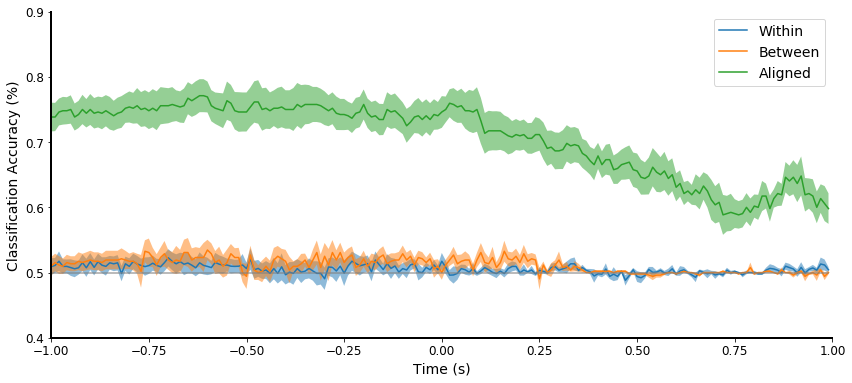

In [36]:
# Plot the results across time, between classification approaches
plot_results(times, results, labels)

In [ ]:
raise ValueError('Stop Here')

## Trajectory Plots

Average of the aligned data, within event type

In [ ]:
%matplotlib notebook

import hypertools as hyp

In [ ]:
al_1 = np.concatenate([dat[0:20, :, :] for dat in aligned_data], 0)
al_2 = np.concatenate([dat[20:, :, :] for dat in aligned_data], 0)

avg_al_1 = np.mean(al_1, 0)
avg_al_2 = np.mean(al_2, 0)

In [ ]:
np.save('avg_al_1', avg_al_1)
np.save('avg_al_2', avg_al_2)

In [ ]:
una_1 = np.concatenate([zscore(dat[0:20, :, :], 0) for dat in all_data], 0)
una_2 = np.concatenate([zscore(dat[20:, :, :], 0) for dat in all_data], 0)

avg_una_1 = np.mean(una_1, 0)
avg_una_2 = np.mean(una_2, 0)

In [ ]:
np.save('avg_una_1', avg_una_1)
np.save('avg_una_2', avg_una_2)

In [ ]:
# Load data - aligned data
avg_al_1 = np.load('avg_al_1.npy')
avg_al_2 = np.load('avg_al_2.npy')

In [ ]:
# Aligned data
hyp.plot([avg_al_1.T, avg_al_2.T], animate=True)#, chemtrails=True)

In [ ]:
# Load data - unaligned data
avg_una_1 = np.load('avg_una_1.npy')
avg_una_2 = np.load('avg_una_2.npy')

In [ ]:
# Unaligned data
hyp.plot([avg_al_1.T, avg_al_2.T], animate=True)#, chemtrails=True)

In [ ]:
subj_ind = 2

In [ ]:
#
hyp.plot([np.mean(aligned_data[subj_ind][0:20], 0), np.mean(aligned_data[subj_ind][21:], 0)],
         animate=True, chemtrails=True)

# Single Trial:
#hyp.plot([aligned_data[subj_ind][0, :, :], aligned_data[subj_ind][-1, :, :]], animate=True, title='Aligned')

In [ ]:
hyp.plot([np.mean(all_data[subj_ind][0:20], 0), np.mean(all_data[subj_ind][21:], 0)],
         animate=True)#, chemtrails=True)

# Single Trial:
#hyp.plot([all_data[subj_ind][:, 0:200], all_data[subj_ind][:, -200:]], animate=True, title='Unaligned')

#### CHECKS
Compare hyperaligned to unaligned data

In [ ]:
# Note: these checks are for test cases which use a group of the same data copied over
#print(np.all(all_data[0] == all_data[1]))
#print(np.all(aligned_data[0] == aligned_data[1]))
#print(np.all(aligned_data[0] == all_data[0]))

## Check random rotations

In [ ]:
# Random rotation matrix
#rot = np.random.random(size=n_chs*n_chs).reshape([n_chs, n_chs])

In [ ]:
# Rotation by random matrix
#twod_dat = deepcopy(all_data)
#twod_dat = [np.dot(rot, dat) for dat in twod_dat]
#twod_dat_3d = [make_3d(dat) for dat in twod_dat]

In [ ]:
# Check within subject prediction of random data
#within_rand_scores = within_subj_classification(twod_dat_3d, all_labels)
#print_avg('Within Rand', np.mean(within_rand_scores))

In [ ]:
# Between subject classification
#rand_btwn_scores = btwn_subj_classication(twod_dat_3d, all_labels)

In [ ]:
# Check outcome - average across all subjects
#avg_rand_btwn = np.mean(rand_btwn_scores)
#print_avg('Random Btwn-Subj Prediction', avg_rand_btwn)

## PyMVPA

Apply hyperalignment implementation from the PyMVPA package.

Note: this requires being in a Py2 environment with PyMVPA available.

In [37]:
from mvpa2.datasets.base import Dataset
from mvpa2.algorithms.hyperalignment import Hyperalignment

### Align All

Use all data to align, and train on same data.

In [89]:
# Data organization - extract matrices, and flatten to continuous data
all_data_2d = [make_2d(dat) for dat in all_data]

In [90]:
# Re-organize data into PyMVPA datasets objects
datasets = [Dataset(dat.T) for dat in all_data_2d]

In [91]:
# Run hyperalignment, and get the transformation matrices
hyper_aligner = Hyperalignment(level2_niter=0, zscore_all=False, zscore_common=False)
#hyper_aligner.train(datasets)
mappers = hyper_aligner(datasets)

In [92]:
# Apply the transformations to each dataset, and re-organize data
#   This applies the projection to the 2D data, transpose, and split back into epochs
aligned_datasets = []
for dataset, mapper in zip(datasets, mappers):
    aligned_datasets.append(make_3d(mapper.forward(dataset).samples.T, N_EPOCHS))
aligned_same_datasets = aligned_datasets

In [93]:
# Check within subject prediction of aligned data
within_al2_scores = within_subj_classification(aligned_datasets, all_labels)
print_avg('Within Al2', np.mean(within_al2_scores))

Within Al2: 51.68%


In [94]:
# Between subject classification after PyMVPA hyperalignment
btwn_al2_scores = btwn_subj_classication(aligned_datasets, all_labels)

In [95]:
# Check average performance
avg_btwn_al2 = np.mean(btwn_al2_scores)
print_avg('Aligned-2 Btwn Scores', avg_btwn_al2)

Aligned-2 Btwn Scores: 81.15%


In [96]:
# Check performance within each subject
print_avgs('Between Subj Aligned Data', btwn_al2_scores)

Between Subj Aligned Data:
	0 	 0.88
	1 	 0.90
	2 	 0.65
	3 	 0.65
	4 	 0.75
	5 	 0.70
	6 	 0.82
	7 	 0.80
	8 	 0.93
	9 	 0.88
	10 	 0.85
	11 	 0.82
	12 	 0.93


In [149]:
ts_btwn_al_scores = time_btwn_subj_classification(aligned_same_datasets, all_labels)

## PYMVPA - Align & Predict on Different

In [177]:
n_align = 30
n_pred = N_EPOCHS - n_align

inds = list(range(N_EPOCHS))
np.random.shuffle(inds)

alig_inds = inds[0:n_align]
pred_inds = inds[n_align:]

In [178]:
# Sample code to select specific chunk of indices for prediction

# n_align = 30
# n_pred = N_EPOCHS - n_align

# inds = list(range(N_EPOCHS))
# np.random.shuffle(inds)

# i = 3*10
# pred_inds = inds[i:i+n_pred]
# alig_inds = np.delete(inds, range(i, i+n_pred))

In [179]:
# Check that there is no overlap in indices used for alignment vs prediction
assert not set(alig_inds).intersection(pred_inds)

In [180]:
# #
# skip_by = 8

# #
# inds = list(range(N_EPOCHS))

# inds_a = inds[0::skip_by]
# inds_b = list(set(inds) - set(inds_a))
# inds_b.sort()

# alig_inds, pred_inds = inds_a, inds_b

In [181]:
print('# Aligned: ', len(alig_inds))
print('# Predict: ', len(pred_inds))

('# Aligned: ', 30)
('# Predict: ', 10)


#### Short detour to re-calculate the aligned-same performance using only the prediction indices to be used in align-diff

In [182]:
aligned_same_predset = list(np.array(aligned_same_datasets)[:, pred_inds, :, :])
dif_labels = [labels[pred_inds] for labels in all_labels]
ts_btwn_al_scores_pred = time_btwn_subj_classification(aligned_same_predset, dif_labels)

#### Now, back to calculating align-diff

In [183]:
# Subset which trials to use for hyperalignment and for prediction
alig_data_2d = [make_2d(dat[alig_inds, :, :]) for dat in all_data]
pred_data_2d = [make_2d(dat[pred_inds, :, :]) for dat in all_data]

In [184]:
# Re-organize data into PyMVPA datasets objects
alig_datasets = [Dataset(dat.T) for dat in alig_data_2d]
pred_datasets = [Dataset(dat.T) for dat in pred_data_2d]

In [185]:
# Run hyperalignment, and get the transformation matrices
hyper_aligner = Hyperalignment(level2_niter=0, zscore_all=False, zscore_common=False)
mappers = hyper_aligner(alig_datasets)

In [186]:
# Apply the transformations to each dataset, and re-organize data - ON SUBSET DATA
#   This applies the projection to the 2D data, transpose, and split back into epochs
aligned_datasets = []
for dataset, mapper in zip(pred_datasets, mappers):
    aligned_datasets.append(make_3d(mapper.forward(dataset).samples.T, len(pred_inds)))
    
dif_labels = [labels[pred_inds] for labels in all_labels]

In [187]:
btwn_al2_dif_scores = btwn_subj_classication(aligned_datasets, dif_labels)
print_avg('Aligned-2 Btwn Scores', np.mean(btwn_al2_dif_scores))
print_avgs('Between Subj Aligned Data', btwn_al2_dif_scores)

Aligned-2 Btwn Scores: 60.00%
Between Subj Aligned Data:
	0 	 0.50
	1 	 0.80
	2 	 0.60
	3 	 0.50
	4 	 0.60
	5 	 0.60
	6 	 0.60
	7 	 0.60
	8 	 0.60
	9 	 0.60
	10 	 0.60
	11 	 0.60
	12 	 0.60


In [188]:
ts_btwn_dif_scores = time_btwn_subj_classification(aligned_datasets, dif_labels)


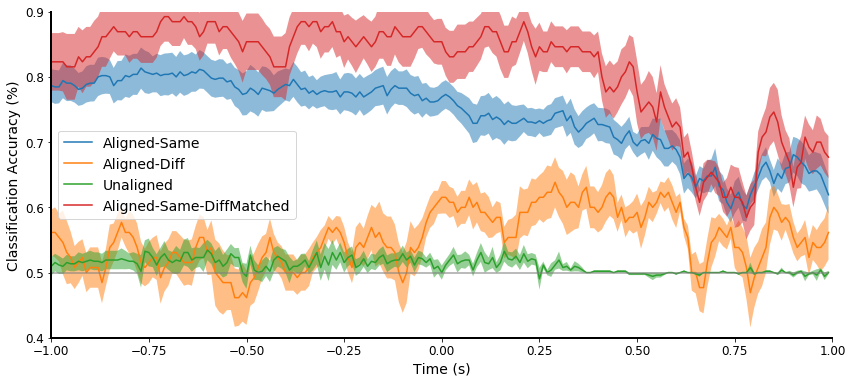

In [189]:
plot_results(times, [ts_btwn_al_scores, ts_btwn_dif_scores, ts_btwn_scores, ts_btwn_al_scores_pred],
             ['Aligned-Same', 'Aligned-Diff', 'Unaligned', 'Aligned-Same-DiffMatched'])

#### Compare between the two hyperalignment implementations

In [ ]:
# Check the magnitude of differences between aligned data
#diff = aligned_datasets[0] - aligned_data[0]

In [ ]:
#print('Avg Magnitude Diff', np.mean(np.abs(diff)))
#print('Avg Magnitude Data', np.mean(np.abs(aligned_datasets[0])))

In [ ]:
# Check number of overlapping points
#from __future__ import division
#np.sum(np.isclose(aligned_datasets[0], aligned_data[0])) / aligned_data[0].size

## Victory Party.

Soon...